In [1]:
print("--- Environment ---")

import sys, pkg_resources
print("Python: " + sys.version)

for package in pkg_resources.working_set:
    print(package.key.ljust(20), package.version)

--- Environment ---
Python: 3.8.8 (default, Feb 19 2021, 16:53:21) [GCC]
tornado              6.1
tensorflow           2.4.1
scipy                1.6.2
pyzmq                22.0.3
protobuf             3.15.8
pillow               8.2.0
numpy                1.19.5
matplotlib           3.4.1
kiwisolver           1.3.1
h5py                 2.10.0
grpcio               1.32.0
wrapt                1.12.1
wheel                0.36.2
werkzeug             1.0.1
wcwidth              0.2.5
urllib3              1.26.4
typing-extensions    3.7.4.3
traitlets            5.0.5
termcolor            1.1.0
tensorflow-estimator 2.4.0
tensorboard          2.5.0
tensorboard-plugin-wit 1.8.0
tensorboard-data-server 0.6.0
six                  1.15.0
setuptools           56.0.0
rsa                  4.7.2
requests             2.25.1
requests-oauthlib    1.3.0
python-dateutil      2.8.1
pyparsing            2.4.7
pygments             2.8.1
pyasn1               0.4.8
pyasn1-modules       0.2.8
ptyprocess          

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pathlib
from scipy.io import loadmat

In [3]:
data_cifar = loadmat(str(pathlib.Path().absolute()) + '/cifar10/train1.mat')
data_cifar2 = loadmat(str(pathlib.Path().absolute()) + '/cifar10/train2.mat')

data_validation_cifar = loadmat(str(pathlib.Path().absolute()) + '/cifar10/valid.mat')

data_test_cifar = loadmat(str(pathlib.Path().absolute()) + '/cifar10/test.mat')

X_cifar_test = data_test_cifar['Xt']
S_cifar_test = data_test_cifar['St']

X_cifar_training = np.concatenate((data_cifar['Xtr'], data_cifar2['Xtr']))
S_cifar_training = np.concatenate((data_cifar['Str'], data_cifar2['Str']))

X_cifar_validation = data_validation_cifar['Xv']
S_cifar_validation = data_validation_cifar['Sv']

# # ELM X
# # We ew concatenate a column of 1's to account for the V0 of each neuron later on
X_cifar_training_elm = np.concatenate((np.transpose(np.array([np.ones(X_cifar_training.shape[0])])), X_cifar_training), axis=1)
X_cifar_validation_elm = np.concatenate((np.transpose(np.array([np.ones(X_cifar_validation.shape[0])])), X_cifar_validation), axis=1)
X_cifar_test_elm = np.concatenate((np.transpose(np.array([np.ones(X_cifar_test.shape[0])])), X_cifar_test), axis=1)

print("X_cifar_training:".ljust(30), X_cifar_training.shape)
print("S_cifar_training:".ljust(30), S_cifar_training.shape)

print("X_cifar_validation:".ljust(30), X_cifar_validation.shape)
print("S_cifar_validation:".ljust(30), S_cifar_validation.shape)

print("X_cifar_test:".ljust(30), X_cifar_test.shape)
print("S_cifar_test:".ljust(30), S_cifar_test.shape)

print("X_cifar_training_elm:".ljust(30), X_cifar_training_elm.shape)
print("X_cifar_validation_elm:".ljust(30), X_cifar_validation_elm.shape)
print("X_cifar_test_elm:".ljust(30), X_cifar_test_elm.shape)


X_cifar_training:              (40000, 3072)
S_cifar_training:              (40000, 10)
X_cifar_validation:            (10000, 3072)
S_cifar_validation:            (10000, 10)
X_cifar_test:                  (10000, 3072)
S_cifar_test:                  (10000, 10)
X_cifar_training_elm:          (40000, 3073)
X_cifar_validation_elm:        (10000, 3073)
X_cifar_test_elm:              (10000, 3073)


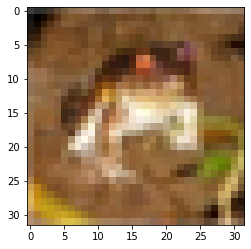

6


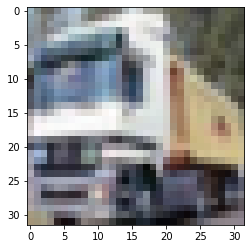

9


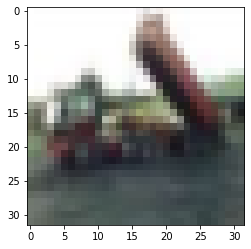

9


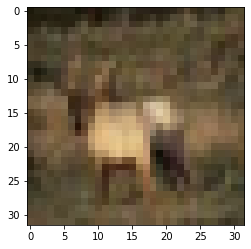

4


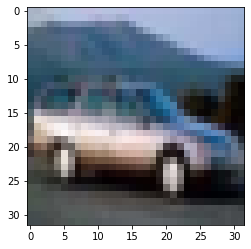

1


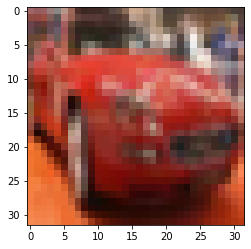

1


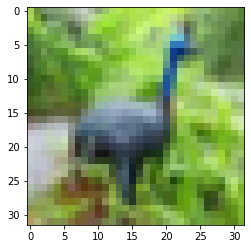

2


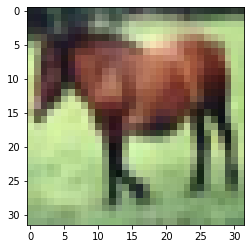

7


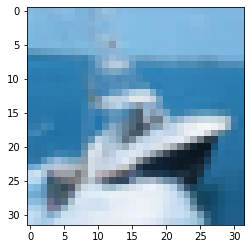

8


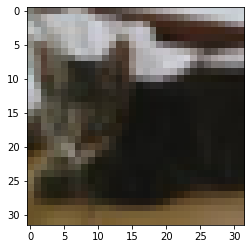

3


In [4]:
def display_sample_cifar(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    im_r = sample[0:1024].reshape(32, 32)
    im_g = sample[1024:2048].reshape(32, 32)
    im_b = sample[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))       

    plt.imshow(img) 
    plt.show()

def get_class_from_sample(sample: np.ndarray):
    return np.where(sample == np.amax(sample))[0][0]

for i in range(10):
    display_sample_cifar(X_cifar_training[i])
    print(get_class_from_sample(S_cifar_training[i]))



In [10]:
def leaky_relu(table):
     return np.where(table > 0, table,  0.02 * table)

def relu(table):
     return np.where(table > 0, table,  0)

def sigmoid(table):
    return 1. / (1. + np.exp(-table))

def get_h(X, V, activation_function): 
    V_ = np.matmul(X, V)
    return activation_function(V_)

def get_w(X, S, c): 
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), S)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w

def get_rates_from_c_values(X, S, c_values, Ws = []):
    hit_rates = []
    
    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        print(c)
        
        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, S, c)
            Ws.append(W)

        S_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(S_estimate):
            estimated_class = np.where(estimate == np.amax(estimate))[0][0]
            if estimated_class == get_class_from_sample(S[index]):
                hits += 1
        hit_rates.append(hits/S_estimate.shape[0])
    return hit_rates, Ws

In [67]:
c_values = [pow(2,d) for d in range(-10, 18, 2)]

hit_rates_training, Ws = get_rates_from_c_values(X_cifar_training, S_cifar_training, c_values)

0.0009765625


KeyboardInterrupt: 

In [26]:
hit_rates_validation, _ = get_rates_from_c_values(X_cifar_validation, S_cifar_validation, c_values, Ws)

0.0009765625
0.00390625
0.015625
0.0625
0.25
1
4
16
64
256
1024
4096
16384
65536


Best c value: 256 
Performance of this vaule: 0.3977


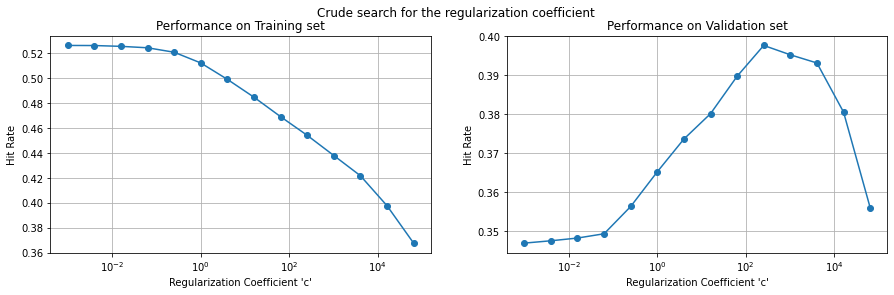

In [27]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this vaule: {}".format(best_c, hit_rates_validation[best_c_index]))

In [28]:
step =  0.1 * (4 * best_c - best_c / 4);

fine_c_values = range(int(best_c/4), int(4*best_c), int(step))

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(X_cifar_training, S_cifar_training, fine_c_values)

64
160
256
352
448
544
640
736
832
928


In [29]:
hit_rates_validation_fine, _ = get_rates_from_c_values(X_cifar_validation, S_cifar_validation, fine_c_values, Ws_fine)

64
160
256
352
448
544
640
736
832
928


Best c value: 352 
Performance of this vaule: 0.398


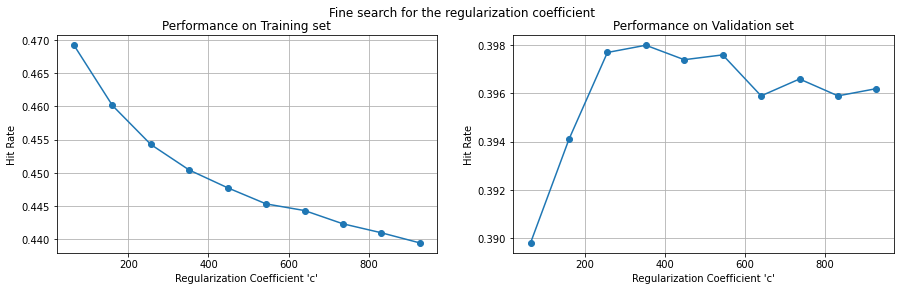

In [30]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this vaule: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [34]:
W = get_w(X_cifar_training, S_cifar_training, best_c)

[[ 0.00075261  0.00474728 -0.00245657 ...  0.00915439  0.00903786
  -0.00372566]
 [-0.00472669 -0.00497679  0.00492788 ... -0.00316265  0.00281166
  -0.00559473]
 [-0.00950302 -0.00102627  0.00579845 ...  0.00373882  0.00122915
  -0.00848631]
 ...
 [-0.00211121  0.00077212  0.00291204 ... -0.01519827  0.01330157
   0.00281395]
 [-0.00261907 -0.00150301 -0.0054057  ... -0.01347779  0.01906961
   0.00825757]
 [-0.00879862  0.00262557 -0.00639207 ... -0.00515326  0.01719375
   0.00739013]]


1 9 8


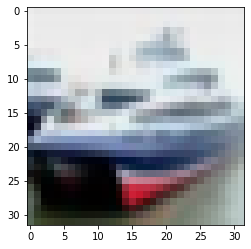

4 4 6


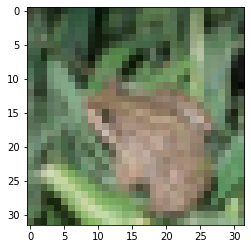

6 3 1


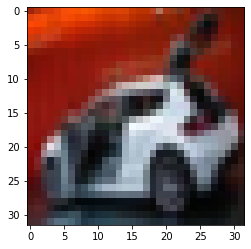

8 5 3


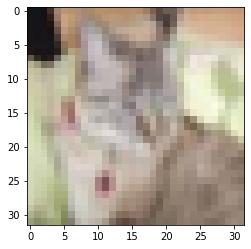

Performance on test set: 0.0004


In [48]:
S_t_estimate = np.matmul(X_cifar_test, W)

hits = 0
confusion_matrix = np.zeros((10, 10), dtype=int)

ja_foi = []

for index, estimate in enumerate(S_t_estimate):
    estimated_class = np.where(estimate == np.amax(estimate))[0][0]
    if estimated_class == get_class_from_sample(S_cifar_test[index]):
        hits += 1
        confusion_matrix[estimated_class][estimated_class] += 1
    else:
        confusion_matrix[estimated_class][get_class_from_sample(S_cifar_test[index])] += 1
        # parte para colher exemplos de classificacoes equivocadas
        if not(get_class_from_sample(S_cifar_test[index]) in ja_foi):
            print(index, estimated_class, get_class_from_sample(S_cifar_test[index]))
            display_sample_cifar(X_cifar_test[index])
            ja_foi.append(get_class_from_sample(S_cifar_test[index]))
        if len(ja_foi) >= 4:
            break

print("Performance on test set: {}".format(hits/S_t_estimate.shape[0]))


In [43]:
print(confusion_matrix)

# condition positive (P) per class
P = np.zeros(10, dtype=int)

# condition negative (N) per class
N = np.zeros(10, dtype=int)

# true positive (TP) per class
TP = np.zeros(10, dtype=int)

# true negative (TN) per class
TN = np.zeros(10, dtype=int)

# false positive (FP) per class *******
FP = np.zeros(10, dtype=int)

# false negative (FN) per class *******
FN = np.zeros(10, dtype=int)

sum_along_lines = np.sum(confusion_matrix, 1)
sum_along_columns = np.sum(confusion_matrix, 0)

for sample in S_cifar_test:
    real_class = get_class_from_sample(sample)

    # P
    P[real_class] += 1

    # N
    for i in range(10):
        if i != real_class:
            N[i] += 1

for i in range(10):
    # TP
    TP[i] = confusion_matrix[i][i]

    # TN
    for j in range(10):
        if (j != i):
            TN[i] += confusion_matrix[j][j]

    # FP
    FP[i] = sum_along_lines[i] - confusion_matrix[i][i]
    FN[i] = sum_along_columns[i] - confusion_matrix[i][i]


# sensitivity, recall, hit rate, or true positive rate (TPR) per class
TPR = TP/P

# specificity, selectivity or true negative rate (TNR) per class
TNR = TN/N

# precision or positive predictive value (PPV) per class
PPV = TP / (TP + FP)

# negative predictive value (NPV) per class
NPV = TN / (TN + FN)

# miss rate or false negative rate (FNR) per class
FNR = FN / P

print("P:", P)
print("N:", N)
print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)
print("TPR:", TPR)
print("TNR:", TNR)
print("PPV:", PPV)
print("NPV:", NPV)
print("FNR:", FNR)

[[498  69 126  65  70  34  22  48 142  76]
 [ 48 493  52  79  38  68  61  66  87 196]
 [ 28   6 225  70 107  77  60  47   5  12]
 [ 22  18  65 168  49 118  71  33  10  11]
 [ 17  13  96  40 266  64  83  57   5   9]
 [ 23  34  89 218  84 346  78  79  38  23]
 [ 30  32 153 147 164  89 507  37  18  51]
 [ 57  60  92  59 141  86  49 466  20  51]
 [185 107  63  69  39  69  30  58 572 105]
 [ 92 168  39  85  42  49  39 109 103 466]]
P: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
N: [9000 9000 9000 9000 9000 9000 9000 9000 9000 9000]
TP: [498 493 225 168 266 346 507 466 572 466]
TN: [3509 3514 3782 3839 3741 3661 3500 3541 3435 3541]
FP: [652 695 412 397 384 666 721 615 725 726]
FN: [502 507 775 832 734 654 493 534 428 534]
TPR: [0.498 0.493 0.225 0.168 0.266 0.346 0.507 0.466 0.572 0.466]
TNR: [0.38988889 0.39044444 0.42022222 0.42655556 0.41566667 0.40677778
 0.38888889 0.39344444 0.38166667 0.39344444]
PPV: [0.43304348 0.41498316 0.35321821 0.29734513 0.40923077 0.34189723
 0.41286

In [14]:
sigma = 0.2
mu = 0
# 3072 wieghts from X input and 1 from bias input V0
V  = sigma * np.random.randn(3073, 3500) + mu

In [21]:
c_values = [pow(2,d) for d in range(-10, 18, 2)]

hit_rates_training, Ws = get_rates_from_c_values(get_h(X_cifar_training_elm, V, sigmoid), S_cifar_training, c_values)

262144
524288
1048576
2097152


In [24]:
hit_rates_validation, _ = get_rates_from_c_values(get_h(X_cifar_validation_elm, V, sigmoid), S_cifar_validation, c_values, Ws)

262144
524288
1048576
2097152


Best c value: 262144 
Performance of this vaule: 0.3414


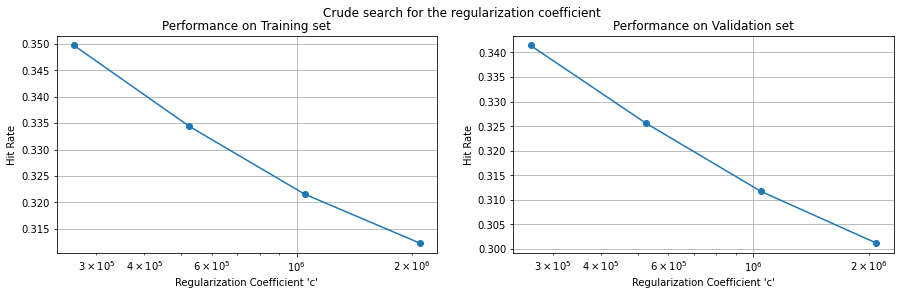

In [25]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

print("Best c value: {} \nPerformance of this vaule: {}".format(best_c, hit_rates_validation[best_c_index]))

In [92]:
step =  0.1 * (4* best_c - best_c / 4);

fine_c_values = np.arange(best_c/4, 4*best_c, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(get_h(X_cifar_training_elm, V, leaky_relu), S_cifar_training, fine_c_values)

8192.0
20480.0
32768.0
45056.0
57344.0
69632.0
81920.0
94208.0
106496.0
118784.0


In [93]:
hit_rates_validation_fine, _ = get_rates_from_c_values(get_h(X_cifar_validation_elm, V, leaky_relu), S_cifar_validation, fine_c_values, Ws_fine)

8192.0
20480.0
32768.0
45056.0
57344.0
69632.0
81920.0
94208.0
106496.0
118784.0


Best c value: 32768.0 
Performance of this vaule: 0.4594


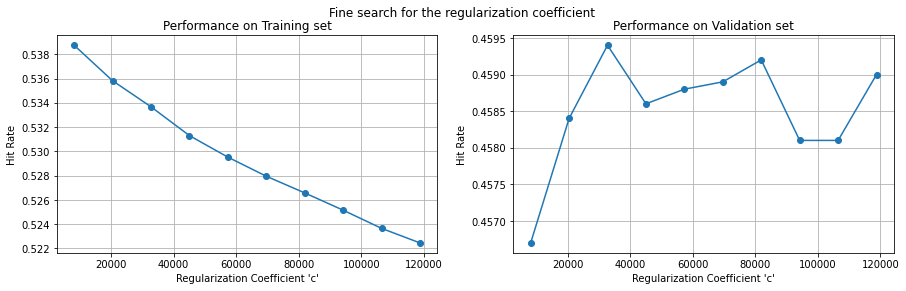

In [94]:
fig, axs = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

print("Best c value: {} \nPerformance of this vaule: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [95]:
W_elm = get_w(get_h(X_cifar_training_elm, V, leaky_relu), S_cifar_training, best_c)

In [96]:
S_t_estimate = np.matmul(get_h(X_cifar_test_elm, V, leaky_relu), W_elm)

hits = 0
confusion_matrix = np.zeros((10, 10), dtype=int)

ja_foi = []

for index, estimate in enumerate(S_t_estimate):
    estimated_class = np.where(estimate == np.amax(estimate))[0][0]
    if estimated_class == get_class_from_sample(S_cifar_test[index]):
        hits += 1
        confusion_matrix[estimated_class][estimated_class] += 1
    else:
        confusion_matrix[estimated_class][get_class_from_sample(S_cifar_test[index])] += 1
        # parte para colher exemplos de classificacoes equivocadas
        # if not(get_class_from_sample(S_cifar_test[index]) in ja_foi):
        #     print(index, estimated_class, get_class_from_sample(S_cifar_test[index]))
        #     display_sample_cifar(X_cifar_test[index])
        #     ja_foi.append(get_class_from_sample(S_cifar_test[index]))
        # if len(ja_foi) >= 4:
        #     break

print("Performance on test set: {}".format(hits/S_t_estimate.shape[0]))


Performance on test set: 0.4568


In [77]:
print(confusion_matrix)

# condition positive (P) per class
P = np.zeros(10, dtype=int)

# condition negative (N) per class
N = np.zeros(10, dtype=int)

# true positive (TP) per class
TP = np.zeros(10, dtype=int)

# true negative (TN) per class
TN = np.zeros(10, dtype=int)

# false positive (FP) per class *******
FP = np.zeros(10, dtype=int)

# false negative (FN) per class *******
FN = np.zeros(10, dtype=int)

sum_along_lines = np.sum(confusion_matrix, 1)
sum_along_columns = np.sum(confusion_matrix, 0)

for sample in S_cifar_test:
    real_class = get_class_from_sample(sample)

    # P
    P[real_class] += 1

    # N
    for i in range(10):
        if i != real_class:
            N[i] += 1

for i in range(10):
    # TP
    TP[i] = confusion_matrix[i][i]

    # TN
    for j in range(10):
        if (j != i):
            TN[i] += confusion_matrix[j][j]

    # FP
    FP[i] = sum_along_lines[i] - confusion_matrix[i][i]
    FN[i] = sum_along_columns[i] - confusion_matrix[i][i]


# sensitivity, recall, hit rate, or true positive rate (TPR) per class
TPR = TP/P

# specificity, selectivity or true negative rate (TNR) per class
TNR = TN/N

# precision or positive predictive value (PPV) per class
PPV = TP / (TP + FP)

# negative predictive value (NPV) per class
NPV = TN / (TN + FN)

# miss rate or false negative rate (FNR) per class
FNR = FN / P

print("P:", P)
print("N:", N)
print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)
print("TPR:", TPR)
print("TNR:", TNR)
print("PPV:", PPV)
print("NPV:", NPV)
print("FNR:", FNR)

[[539  33 110  48  64  24  16  41 107  45]
 [ 46 567  38  56  23  41  29  42  83 195]
 [ 45   8 309  84 127  85  92  43  15  12]
 [  7  19  59 219  45 138  52  54  20  25]
 [ 24   9 119  70 370  71  95  60  11   9]
 [ 11  25  68 198  53 351  52  71  23  20]
 [ 36  37 138 136 148 117 578  53  17  41]
 [ 42  40  87  74 100  95  30 509  22  53]
 [187  83  46  48  45  45  25  40 643  91]
 [ 63 179  26  67  25  33  31  87  59 509]]
P: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
N: [9000 9000 9000 9000 9000 9000 9000 9000 9000 9000]
TP: [539 567 309 219 370 351 578 509 643 509]
TN: [4055 4027 4285 4375 4224 4243 4016 4085 3951 4085]
FP: [488 553 511 419 468 521 723 543 610 570]
FN: [461 433 691 781 630 649 422 491 357 491]
TPR: [0.539 0.567 0.309 0.219 0.37  0.351 0.578 0.509 0.643 0.509]
TNR: [0.45055556 0.44744444 0.47611111 0.48611111 0.46933333 0.47144444
 0.44622222 0.45388889 0.439      0.45388889]
PPV: [0.5248296  0.50625    0.37682927 0.34326019 0.44152745 0.40252294
 0.44427